In [1]:
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import cv2

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [3]:

import warnings
warnings.filterwarnings('ignore')

import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
from jupyterplot import ProgressPlot

path=r"E:\hackathon\train_test_data"
df=pd.read_csv(r"E:\hackathon\train.csv")
labels=[]
image_dir=[]

for i,j in enumerate(df['example_path']):
    x=os.path.join(path,j)
    label=df['label'][i]
    #labels.append(df['label'][i])
    image_dir.append(x)
    if label==1:
        #print(x)
        y=(f"r'{x}"")
        print(y)
        image= plt.imread(y)
        rotated = rotate(image, angle=45, mode = 'wrap')
        path=r"E:\hackathon\augumented_images"
        #cv2.imwrite("E:\hackathon\augumented_images\rotated"
        cv2.imwrite(os.path.join(path , f'rotated{i}.jpg'),rotated)
        image_dir.append(os.path.join(path,f'rotated{i}.jpg'))
        labels.append(label)
        flipLR = np.fliplr(image)
        cv2.imwrite(os.path.join(path ,f'flipLR{i}.jpg'),flipLR)
        image_dir.append(os.path.join(path,f'flipLR{i}.jpg'))              
        labels.append(label)
        flipUD = np.flipud(image)
        cv2.imwrite(os.path.join(path , f'flipUD{i}.jpg'),flipUD)
        image_dir.append(os.path.join(path,f'flipUD{i}.jpg'))
        labels.append(label)
        sigma=0.155
        #add random noise to the image
        noisyRandom = random_noise(image,var=sigma**2)
        cv2.imwrite(os.path.join(path , f'noisyRandom{i}.jpg'),noisyRandom)
        image_dir.append(os.path.join(path,f'noisyRandom{i}.jpg'))
        labels.append(label)
        blurred = gaussian(image,sigma=1,multichannel=True)
        cv2.imwrite(os.path.join(path , f'blurred{i}.jpg'),blurred)
        image_dir.append(os.path.join(path,f'blurred{i}.jpg'))
        labels.append(label)

img=cv2.imread(r'E:\hackathon\augumented_images\train_test_data/train/1286.png')

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self,path,annatation,transform=None):
        self.transform=transform
        self.path=path
        self.annatation=annatation
        #print(path)
        df=pd.read_csv(annatation)
        images_dir=list()
        labels=list()
        images=[]
        for i,j in tqdm(enumerate(df['example_path'])):
            x=os.path.join(self.path,j)
            label=df['label'][i]
            labels.append(label)
            images_dir.append(x)
            image=cv2.imread(x)
            images.append(image)
            if label==1:
                rotated =rotate(image, angle=45, mode = 'wrap')
                images.append(rotated)
                labels.append(label)
                transform = AffineTransform(translation=(25,25))
                wrapShift = warp(image,transform,mode='wrap')
                images.append(wrapShift)
                labels.append(label)
                flipUD = np.flipud(image).copy()
                images.append(flipUD)
                labels.append(label)
            elif label==2:
                rotated =rotate(image, angle=45, mode = 'wrap')
                images.append(rotated)
                labels.append(label)
                flipUD = np.flipud(image).copy()
                images.append(flipUD)
                labels.append(label)
                
        self.images_dir=images_dir
        self.labels=labels
        self.images=images
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image=cv2.imread(self.images_dir[idx])
        target=self.labels[idx]
        image =self.images[idx]
        #print(target)
        if self.transform is not None:
            image=self.transform(image)
            target=torch.tensor(np.eye(3)[target])
        return image,target

In [5]:
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((332, 332)),
  #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [6]:
dataset=CustomImageDataset(path=r"C:\Users\vetsa\Desktop\Jupyter\My Projects\Hackathon_Schneider\train_test_data",
                           annatation=r"C:\Users\vetsa\Desktop\Jupyter\My Projects\Hackathon_Schneider\train.csv",
                           transform=train_transforms)

1714it [00:37, 45.92it/s]


In [13]:
len(dataset)

3618

In [14]:
pretrain_set, test_set = torch.utils.data.random_split(dataset,[2894,724])

In [15]:
train_set, val_set = torch.utils.data.random_split(pretrain_set,[2605,289])

In [16]:
size_batch = 16
train_dataloader = DataLoader(train_set, batch_size=16,shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1,shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1,shuffle=True)

In [17]:
import torch.nn as nn
from torchsummary import summary

class MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [18]:
device = torch.device("cuda:0")
model = MobileNetV1(3,3)
model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

100%|██████████| 163/163 [01:12<00:00,  2.26it/s]


Epoch 1 		 Training Loss: 9.832229418726387 		 Validation Loss: 236.04475706070662
Validation Loss Decreased(inf--->236.044757) 	 Saving The Model


100%|██████████| 163/163 [02:41<00:00,  1.01it/s]


Epoch 2 		 Training Loss: 8.390487030654185 		 Validation Loss: 204.8779345899702
Validation Loss Decreased(236.044757--->204.877935) 	 Saving The Model


100%|██████████| 163/163 [02:41<00:00,  1.01it/s]


Epoch 3 		 Training Loss: 7.589609956314234 		 Validation Loss: 179.24240402513533
Validation Loss Decreased(204.877935--->179.242404) 	 Saving The Model


100%|██████████| 163/163 [00:55<00:00,  2.92it/s]


Epoch 4 		 Training Loss: 6.822971173951373 		 Validation Loss: 210.54424301799736


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 5 		 Training Loss: 6.9310924451071445 		 Validation Loss: 173.55397136172667
Validation Loss Decreased(179.242404--->173.553971) 	 Saving The Model


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 6 		 Training Loss: 6.068586256824487 		 Validation Loss: 217.52657895875018


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 7 		 Training Loss: 5.799347361551813 		 Validation Loss: 233.48856379112112


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 8 		 Training Loss: 5.428677576186724 		 Validation Loss: 186.6396236487917


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 9 		 Training Loss: 4.781262205080943 		 Validation Loss: 203.18547471808893


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 10 		 Training Loss: 4.469089463065649 		 Validation Loss: 191.1154966147434


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 11 		 Training Loss: 3.7956936509366264 		 Validation Loss: 197.81454284989968


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 12 		 Training Loss: 3.631702274355267 		 Validation Loss: 194.36168161500837


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 13 		 Training Loss: 3.427410893448044 		 Validation Loss: 194.04558122400522


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 14 		 Training Loss: 2.51642851185189 		 Validation Loss: 192.5181984324745


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 15 		 Training Loss: 2.2335474976626157 		 Validation Loss: 214.44964475517054


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 16 		 Training Loss: 2.595082805060808 		 Validation Loss: 201.79153310547053


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 17 		 Training Loss: 1.8099561404414652 		 Validation Loss: 259.7374794292921


100%|██████████| 163/163 [00:37<00:00,  4.34it/s]


Epoch 18 		 Training Loss: 1.5994401799032183 		 Validation Loss: 238.18314895371873


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 19 		 Training Loss: 1.9529762403149113 		 Validation Loss: 245.36653015476918


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 20 		 Training Loss: 1.199985797388177 		 Validation Loss: 241.64348866321177


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 21 		 Training Loss: 1.265277345530162 		 Validation Loss: 262.85487025131204


100%|██████████| 163/163 [00:37<00:00,  4.33it/s]


Epoch 22 		 Training Loss: 1.5103452031391658 		 Validation Loss: 267.99536408653773


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 23 		 Training Loss: 1.190319433604733 		 Validation Loss: 256.91945196389264


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 24 		 Training Loss: 1.0401392682373374 		 Validation Loss: 322.0584419256653


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 25 		 Training Loss: 1.5299447241653221 		 Validation Loss: 391.4591242835985


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 26 		 Training Loss: 1.2046319030170705 		 Validation Loss: 256.51783591543335


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 27 		 Training Loss: 1.5416969511250547 		 Validation Loss: 245.05972723010655


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 28 		 Training Loss: 0.8964516755372484 		 Validation Loss: 289.26204095225603


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 29 		 Training Loss: 0.8338490300893443 		 Validation Loss: 276.74883809929463


100%|██████████| 163/163 [00:37<00:00,  4.34it/s]


Epoch 30 		 Training Loss: 0.7639976349846094 		 Validation Loss: 321.70577417660195


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 31 		 Training Loss: 0.7613323985419705 		 Validation Loss: 269.5289569766927


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 32 		 Training Loss: 0.6911454180468718 		 Validation Loss: 279.70522743489937


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 33 		 Training Loss: 0.9093161104103605 		 Validation Loss: 360.28063630567624


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 34 		 Training Loss: 1.0233456316851666 		 Validation Loss: 348.6462693351381


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 35 		 Training Loss: 0.9819952792773504 		 Validation Loss: 344.83789691689753


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 36 		 Training Loss: 0.9383039042587591 		 Validation Loss: 300.56056738102785


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 37 		 Training Loss: 1.1768929838514912 		 Validation Loss: 312.159534444752


100%|██████████| 163/163 [00:37<00:00,  4.32it/s]


Epoch 38 		 Training Loss: 0.5838873668445754 		 Validation Loss: 275.72453027036613


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 39 		 Training Loss: 0.6513664028740271 		 Validation Loss: 321.32344379488023


100%|██████████| 163/163 [00:37<00:00,  4.38it/s]


Epoch 40 		 Training Loss: 0.42802686130253664 		 Validation Loss: 328.6839772705613


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 41 		 Training Loss: 0.631843058013688 		 Validation Loss: 373.4166965219971


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 42 		 Training Loss: 1.2147554452347789 		 Validation Loss: 318.424503410816


100%|██████████| 163/163 [00:37<00:00,  4.39it/s]


Epoch 43 		 Training Loss: 0.9823973086788984 		 Validation Loss: 291.54051068029196


100%|██████████| 163/163 [00:37<00:00,  4.38it/s]


Epoch 44 		 Training Loss: 0.5749568037088354 		 Validation Loss: 314.26692188458367


100%|██████████| 163/163 [00:37<00:00,  4.38it/s]


Epoch 45 		 Training Loss: 0.5442755741379113 		 Validation Loss: 339.95645421345574


100%|██████████| 163/163 [00:37<00:00,  4.38it/s]


Epoch 46 		 Training Loss: 0.4643004010140805 		 Validation Loss: 363.42300551418066


100%|██████████| 163/163 [00:37<00:00,  4.39it/s]


Epoch 47 		 Training Loss: 0.7424889203342506 		 Validation Loss: 348.83574813578616


100%|██████████| 163/163 [00:37<00:00,  4.38it/s]


Epoch 48 		 Training Loss: 0.5438959365057768 		 Validation Loss: 320.0335426363292


100%|██████████| 163/163 [00:37<00:00,  4.36it/s]


Epoch 49 		 Training Loss: 0.8992467123145529 		 Validation Loss: 309.90372302185705


100%|██████████| 163/163 [00:37<00:00,  4.37it/s]


Epoch 50 		 Training Loss: 0.5969791484715793 		 Validation Loss: 304.5775697869531


100%|██████████| 163/163 [00:37<00:00,  4.38it/s]


Epoch 51 		 Training Loss: 0.4195455488334493 		 Validation Loss: 357.37860238886975


100%|██████████| 163/163 [00:37<00:00,  4.38it/s]


Epoch 52 		 Training Loss: 0.4019773184690725 		 Validation Loss: 376.58146409912086


100%|██████████| 163/163 [00:52<00:00,  3.13it/s]


Epoch 53 		 Training Loss: 0.49118612385271593 		 Validation Loss: 401.23901121986484


100%|██████████| 163/163 [00:52<00:00,  3.08it/s]


Epoch 54 		 Training Loss: 0.7513537902447072 		 Validation Loss: 372.39750528043544


100%|██████████| 163/163 [00:50<00:00,  3.22it/s]


Epoch 55 		 Training Loss: 0.7584324176683038 		 Validation Loss: 370.0767893305191


100%|██████████| 163/163 [02:39<00:00,  1.02it/s]


Epoch 56 		 Training Loss: 0.4644834335181555 		 Validation Loss: 363.66795252434827


100%|██████████| 163/163 [02:40<00:00,  1.01it/s]


Epoch 57 		 Training Loss: 0.5013431454783196 		 Validation Loss: 360.7182312008316


100%|██████████| 163/163 [02:40<00:00,  1.02it/s]


Epoch 58 		 Training Loss: 0.5004725830298418 		 Validation Loss: 422.78656168234454


100%|██████████| 163/163 [02:40<00:00,  1.02it/s]


Epoch 59 		 Training Loss: 0.5483292607936116 		 Validation Loss: 369.4774645847802


100%|██████████| 163/163 [02:40<00:00,  1.01it/s]


Epoch 60 		 Training Loss: 0.4175793567198005 		 Validation Loss: 303.9817349990707


100%|██████████| 163/163 [02:40<00:00,  1.02it/s]


Epoch 61 		 Training Loss: 0.19556338597688214 		 Validation Loss: 300.67082455056425


100%|██████████| 163/163 [00:39<00:00,  4.14it/s]


Epoch 62 		 Training Loss: 0.4429586659602958 		 Validation Loss: 327.87991170293105


100%|██████████| 163/163 [00:39<00:00,  4.15it/s]


Epoch 63 		 Training Loss: 0.4737586774431566 		 Validation Loss: 378.44274521947807


100%|██████████| 163/163 [00:39<00:00,  4.16it/s]


Epoch 64 		 Training Loss: 0.61313782104538 		 Validation Loss: 384.24709579515314


100%|██████████| 163/163 [00:40<00:00,  4.07it/s]


Epoch 65 		 Training Loss: 0.6610200360637762 		 Validation Loss: 371.4864234350696


100%|██████████| 163/163 [00:45<00:00,  3.59it/s]


Epoch 66 		 Training Loss: 0.5340065828488377 		 Validation Loss: 343.4519023424814


100%|██████████| 163/163 [00:40<00:00,  4.04it/s]


Epoch 67 		 Training Loss: 0.4252435793387561 		 Validation Loss: 334.77698021993456


100%|██████████| 163/163 [00:38<00:00,  4.21it/s]


Epoch 68 		 Training Loss: 0.26493285516965864 		 Validation Loss: 346.60611274095726


100%|██████████| 163/163 [00:38<00:00,  4.18it/s]


Epoch 69 		 Training Loss: 0.16875092133711062 		 Validation Loss: 379.1321572270751


100%|██████████| 163/163 [00:38<00:00,  4.22it/s]


Epoch 70 		 Training Loss: 0.24804620850075784 		 Validation Loss: 380.38895277690784


100%|██████████| 163/163 [00:39<00:00,  4.16it/s]


Epoch 71 		 Training Loss: 0.48460602391878976 		 Validation Loss: 391.76607932725983


100%|██████████| 163/163 [00:42<00:00,  3.86it/s]


Epoch 72 		 Training Loss: 0.4486994979797031 		 Validation Loss: 364.06647627840863


100%|██████████| 163/163 [00:40<00:00,  4.01it/s]


Epoch 73 		 Training Loss: 0.4363174557449297 		 Validation Loss: 347.405879991396


100%|██████████| 163/163 [00:38<00:00,  4.21it/s]


Epoch 74 		 Training Loss: 0.33753818768440347 		 Validation Loss: 353.90927215237645


100%|██████████| 163/163 [00:38<00:00,  4.21it/s]


Epoch 75 		 Training Loss: 0.9616739493228728 		 Validation Loss: 340.8691641420951


100%|██████████| 163/163 [00:39<00:00,  4.13it/s]


Epoch 76 		 Training Loss: 0.6065887134937116 		 Validation Loss: 301.5877227314946


100%|██████████| 163/163 [00:39<00:00,  4.17it/s]


Epoch 77 		 Training Loss: 0.365372125859663 		 Validation Loss: 309.5833400280078


100%|██████████| 163/163 [00:39<00:00,  4.09it/s]


Epoch 78 		 Training Loss: 0.2251141768451332 		 Validation Loss: 297.81549716016036


100%|██████████| 163/163 [00:39<00:00,  4.13it/s]


Epoch 79 		 Training Loss: 0.09394639107334168 		 Validation Loss: 338.8235261143626


100%|██████████| 163/163 [00:39<00:00,  4.12it/s]


Epoch 80 		 Training Loss: 0.1791174503312752 		 Validation Loss: 349.3998401668756


100%|██████████| 163/163 [00:39<00:00,  4.14it/s]


Epoch 81 		 Training Loss: 0.2110413541525816 		 Validation Loss: 369.5772861358139


100%|██████████| 163/163 [00:38<00:00,  4.20it/s]


Epoch 82 		 Training Loss: 0.49839999543786556 		 Validation Loss: 394.05633443959755


100%|██████████| 163/163 [00:39<00:00,  4.17it/s]


Epoch 83 		 Training Loss: 0.5168434729503102 		 Validation Loss: 361.1727106468602


100%|██████████| 163/163 [00:38<00:00,  4.21it/s]


Epoch 84 		 Training Loss: 0.41406793634459 		 Validation Loss: 377.25069342552183


100%|██████████| 163/163 [00:38<00:00,  4.21it/s]


Epoch 85 		 Training Loss: 0.30323342659719715 		 Validation Loss: 357.5007035297457


100%|██████████| 163/163 [00:40<00:00,  4.01it/s]


Epoch 86 		 Training Loss: 0.35761944078882174 		 Validation Loss: 318.3148905834517


100%|██████████| 163/163 [00:44<00:00,  3.64it/s]


Epoch 87 		 Training Loss: 0.46705677723237793 		 Validation Loss: 274.0569293798817


100%|██████████| 163/163 [00:43<00:00,  3.75it/s]


Epoch 88 		 Training Loss: 0.3453380651740389 		 Validation Loss: 338.47861685286915


100%|██████████| 163/163 [00:38<00:00,  4.24it/s]


Epoch 89 		 Training Loss: 0.3378727979940943 		 Validation Loss: 286.1382610265856


100%|██████████| 163/163 [00:38<00:00,  4.19it/s]


Epoch 90 		 Training Loss: 0.24236094249990844 		 Validation Loss: 332.30460169813875


100%|██████████| 163/163 [00:38<00:00,  4.18it/s]


Epoch 91 		 Training Loss: 0.21830275136890576 		 Validation Loss: 351.2706751237426


100%|██████████| 163/163 [00:38<00:00,  4.22it/s]


Epoch 92 		 Training Loss: 0.16793251738927573 		 Validation Loss: 359.72746568335475


100%|██████████| 163/163 [00:38<00:00,  4.22it/s]


Epoch 93 		 Training Loss: 0.20911478095013009 		 Validation Loss: 390.25383445320495


100%|██████████| 163/163 [00:38<00:00,  4.19it/s]


Epoch 94 		 Training Loss: 0.22883700931321968 		 Validation Loss: 351.9038587608286


100%|██████████| 163/163 [00:39<00:00,  4.11it/s]


Epoch 95 		 Training Loss: 0.24431079557591673 		 Validation Loss: 373.12371243520374


100%|██████████| 163/163 [00:40<00:00,  4.00it/s]


Epoch 96 		 Training Loss: 0.3117344944832426 		 Validation Loss: 510.3514772276992


100%|██████████| 163/163 [00:38<00:00,  4.21it/s]


Epoch 97 		 Training Loss: 0.6761309091844894 		 Validation Loss: 415.13158518281375


100%|██████████| 163/163 [00:38<00:00,  4.21it/s]


Epoch 98 		 Training Loss: 0.42345238415295744 		 Validation Loss: 347.6656525691799


100%|██████████| 163/163 [00:39<00:00,  4.14it/s]


Epoch 99 		 Training Loss: 0.3913274537469074 		 Validation Loss: 364.2389034818283


100%|██████████| 163/163 [00:39<00:00,  4.10it/s]


Epoch 100 		 Training Loss: 0.40782841319656526 		 Validation Loss: 335.4001933086794


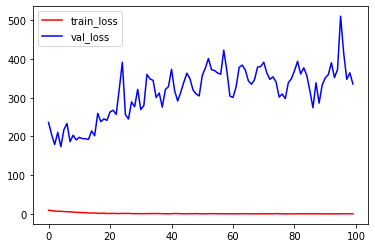

In [19]:
num_epochs = 100
min_valid_loss = np.inf
train_losses=[]
val_losses = []
pp = ProgressPlot()

for e in range(num_epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for images,labels in tqdm(train_dataloader):
        if torch.cuda.is_available():
            images, labels = images.to(device, dtype=torch.float), labels.cuda()
        if torch.cuda.is_available():
            model.cuda()
        #labels = torch.eye(3)[labels].to(device)
        #print('imageshape:',images.shape,labels.shape,labels)
        optimizer.zero_grad()
        output = model(images)
        #print(output.shape,labels.shape)
        #labels = labels.to(torch.float32)
        loss = criterion(output,labels)
        
        #loss = criterion(outputs,labels.view(1, -1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()/size_batch
    pp.update(train_loss)
    train_losses.append(train_loss)
    
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for images,labels in val_dataloader:
        if torch.cuda.is_available():
            images, labels = images.to(device, dtype=torch.float), labels.cuda()
        if torch.cuda.is_available():
            model.cuda()
        #labels = torch.eye(15)[labels].to(device)
        
        output = model(images)
        #print(output.shape,labels.shape)
        
        #loss = criterion(output,labels)
        loss = criterion(output, labels)
        #loss = criterion(outputs,labels.view(1, -1))
        valid_loss += loss.item()
    pp.update(valid_loss/289)
    val_losses.append(valid_loss)
    
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        #
        model_scripted = torch.jit.script(model) # Export to TorchScript
        model_scripted.save('MobileNet_unnorm_aug.pt') # Save

pp.finalize()
plt.plot(range(num_epochs),np.array(train_losses), 'r', label='train_loss')
plt.plot(range(num_epochs),np.array(val_losses), 'b', label='val_loss')
plt.legend()

In [ ]:
images.size(0)

In [20]:
model.eval()     # Optional when not using Model Specific layer
for images,labels in test_dataloader:
    if torch.cuda.is_available():
        images, labels = images.to(device, dtype=torch.float), labels.cuda()
    if torch.cuda.is_available():
        model.cuda()
    output = model(images)
    print(torch.argmax(output),torch.argmax(labels))

tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(1, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') t

In [21]:
ground_truth=[]
predection=[]
for img,label in tqdm(test_dataloader):
    output=model(img.to(device).float())
    target=label.to(device)
    #print(torch.argmax(output),torch.argmax(target))
    output=torch.argmax(output).data.cpu().numpy()
    target=torch.argmax(target).data.cpu().numpy()
    ground_truth.append(target)
    predection.append(output)

100%|██████████| 724/724 [00:06<00:00, 108.23it/s]


In [ ]:
#df1=pd.DataFrame({'ground_truth':ground_truth,'predection': predection})

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,f1_score

In [23]:
#x=confusion_matrix(df1['ground_truth'],df1['predections'])
confusion_matrix(ground_truth, predection)

array([[114,  27,  31],
       [  4,  94,  57],
       [ 21,  56, 320]], dtype=int64)

In [24]:
print(classification_report(ground_truth,predection))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       172
           1       0.53      0.61      0.57       155
           2       0.78      0.81      0.80       397

    accuracy                           0.73       724
   macro avg       0.71      0.69      0.70       724
weighted avg       0.74      0.73      0.73       724



In [25]:
f1_score(ground_truth,predection,average='macro')

0.6981383624008929

In [ ]:
# testing data

In [39]:
class Testdataset(Dataset):
    def __init__(self,path,transform=None):
        self.transform=transform
        self.path=path
        images_dir=list()
        for i in os.listdir(self.path):
            x=os.path.join(self.path,i)
            images_dir.append(x)
        self.images_dir=images_dir
    def __len__(self):
        return len(self.images_dir)
    def __getitem__(self, idx):
        image=cv2.imread(self.images_dir[idx])
        if self.transform is not None:
            image=self.transform(image)
            image_dir=self.images_dir[idx]
        return image, image_dir

In [40]:
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((332,332)),
  #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [41]:
path=r"C:\Users\vetsa\Desktop\Jupyter\My Projects\Hackathon_Schneider\train_test_data\train_test_data\test"

In [42]:
dataset=Testdataset(path,train_transforms)

In [43]:
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [44]:
model.eval()
predection=[]
for i in dataset_loader:
    print(i)
    plt.imshow(i[0].permute(1,2,0))
    output=model(img.to(device).float())
    #print(torch.argmax(output),torch.argmax(target))
    output=torch.argmax(output).data.cpu().numpy()
    predection.append(output)
    break

SyntaxError: invalid character in identifier (3497928693.py, line 10)

In [50]:
import re

In [67]:
predection=list()
path_img=list()
model.eval()
for i,j in dataset_loader:
    output=model(i.to(device).float())
    y=str(j)
#     print(re.findall('\d+', y)[0])
    path_img.append(re.findall('\d+', y)[0])
    output=torch.argmax(output[0]).data.cpu().numpy()
    predection.append(output.item())
d=dict(zip(path_img,predection))

In [74]:
df1=pd.DataFrame({'image_path':path_img,'predection':predection})

In [68]:
d

{'195': 0,
 '267': 2,
 '808': 0,
 '1915': 0,
 '1382': 1,
 '976': 1,
 '1125': 0,
 '1262': 2,
 '1490': 0,
 '934': 0,
 '883': 2,
 '864': 1,
 '149': 2,
 '1614': 0,
 '409': 2,
 '588': 1,
 '1527': 0,
 '1513': 2,
 '299': 2,
 '2232': 0,
 '2039': 2,
 '387': 2,
 '211': 2,
 '1514': 2,
 '1739': 1,
 '893': 1,
 '1664': 0,
 '2011': 2,
 '1006': 0,
 '1494': 0,
 '693': 0,
 '1568': 1,
 '716': 2,
 '1877': 2,
 '1257': 1,
 '1251': 1,
 '1187': 2,
 '1742': 2,
 '1843': 1,
 '126': 0,
 '305': 2,
 '776': 2,
 '855': 1,
 '33': 1,
 '2195': 2,
 '610': 0,
 '219': 0,
 '494': 1,
 '2008': 0,
 '1369': 0,
 '508': 1,
 '394': 0,
 '921': 0,
 '78': 0,
 '1559': 2,
 '1270': 0,
 '2342': 0,
 '2228': 0,
 '1048': 1,
 '1975': 0,
 '421': 2,
 '1978': 0,
 '2050': 2,
 '1516': 2,
 '1511': 2,
 '615': 2,
 '1505': 1,
 '711': 2,
 '1644': 2,
 '2131': 2,
 '1484': 2,
 '1873': 0,
 '2174': 1,
 '842': 2,
 '1914': 2,
 '2047': 0,
 '696': 2,
 '1708': 2,
 '2144': 0,
 '2147': 2,
 '34': 1,
 '6': 2,
 '1168': 1,
 '780': 2,
 '1721': 2,
 '515': 0,
 '1449': 2

In [69]:
final_dict = {'target':d}

In [70]:
final_dict

{'target': {'195': 0,
  '267': 2,
  '808': 0,
  '1915': 0,
  '1382': 1,
  '976': 1,
  '1125': 0,
  '1262': 2,
  '1490': 0,
  '934': 0,
  '883': 2,
  '864': 1,
  '149': 2,
  '1614': 0,
  '409': 2,
  '588': 1,
  '1527': 0,
  '1513': 2,
  '299': 2,
  '2232': 0,
  '2039': 2,
  '387': 2,
  '211': 2,
  '1514': 2,
  '1739': 1,
  '893': 1,
  '1664': 0,
  '2011': 2,
  '1006': 0,
  '1494': 0,
  '693': 0,
  '1568': 1,
  '716': 2,
  '1877': 2,
  '1257': 1,
  '1251': 1,
  '1187': 2,
  '1742': 2,
  '1843': 1,
  '126': 0,
  '305': 2,
  '776': 2,
  '855': 1,
  '33': 1,
  '2195': 2,
  '610': 0,
  '219': 0,
  '494': 1,
  '2008': 0,
  '1369': 0,
  '508': 1,
  '394': 0,
  '921': 0,
  '78': 0,
  '1559': 2,
  '1270': 0,
  '2342': 0,
  '2228': 0,
  '1048': 1,
  '1975': 0,
  '421': 2,
  '1978': 0,
  '2050': 2,
  '1516': 2,
  '1511': 2,
  '615': 2,
  '1505': 1,
  '711': 2,
  '1644': 2,
  '2131': 2,
  '1484': 2,
  '1873': 0,
  '2174': 1,
  '842': 2,
  '1914': 2,
  '2047': 0,
  '696': 2,
  '1708': 2,
  '2144': 0

In [71]:
import json 

In [72]:
json_object = json.dumps(final_dict, indent = 4) 
print(json_object)

{
    "target": {
        "195": 0,
        "267": 2,
        "808": 0,
        "1915": 0,
        "1382": 1,
        "976": 1,
        "1125": 0,
        "1262": 2,
        "1490": 0,
        "934": 0,
        "883": 2,
        "864": 1,
        "149": 2,
        "1614": 0,
        "409": 2,
        "588": 1,
        "1527": 0,
        "1513": 2,
        "299": 2,
        "2232": 0,
        "2039": 2,
        "387": 2,
        "211": 2,
        "1514": 2,
        "1739": 1,
        "893": 1,
        "1664": 0,
        "2011": 2,
        "1006": 0,
        "1494": 0,
        "693": 0,
        "1568": 1,
        "716": 2,
        "1877": 2,
        "1257": 1,
        "1251": 1,
        "1187": 2,
        "1742": 2,
        "1843": 1,
        "126": 0,
        "305": 2,
        "776": 2,
        "855": 1,
        "33": 1,
        "2195": 2,
        "610": 0,
        "219": 0,
        "494": 1,
        "2008": 0,
        "1369": 0,
        "508": 1,
        "394": 0,
        "921": 0,
   

In [73]:
with open('data.json', 'w') as f:
    json.dump(json_object, f)

In [81]:
os.makedirs(r"C:\Users\vetsa\Desktop\Jupyter\My Projects\Hackathon_Schneider", exist_ok=True)  
df1.to_csv(r"C:\Users\vetsa\Desktop\Jupyter\My Projects\Hackathon_Schneider\predictions.csv",index=False)

In [83]:
df = pd.read_csv (r"C:\Users\vetsa\Desktop\Jupyter\My Projects\Hackathon_Schneider\prediction.csv")
df.to_json (r"C:\Users\vetsa\Desktop\Jupyter\My Projects\Hackathon_Schneider\predections.json")